![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQqTVdFA4dLpy2gesQruhxt2Cq48T6OLe7nE9jcnQCn8WFpwaAs)
![](https://1.bp.blogspot.com/-mylooQ1NvrA/UoMdk_M49uI/AAAAAAAAEq8/r9x7o9sC-q4/s1600/UFC1-RoyceXArt-02-400-kick-sg.gif)

# 1. Introduction

Hello everyone, this my analysis of UFC Historical data from 1993 to 2019.<br>
I will make an Exploratory Data Analysis, Feature Engineering and predict the winner using the cleaned data provided by the dataset author. Maybe in the future I will make a Kernel with my data cleaning.<br>
The Predictions will be made with [Catboost](https://catboost.ai/) Classifier.
Let's see what files the dataset contains and import [fastai](https://www.fast.ai/) to use Pandas, Numpy and a lot of useful Python Modules, this module rocks.

Note: Still trying to improve the results.

In [1]:
from fastai.imports import *
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ufcdata/raw_fighter_details.csv
/kaggle/input/ufcdata/raw_total_fight_data.csv
/kaggle/input/ufcdata/preprocessed_data.csv
/kaggle/input/ufcdata/data.csv


As said early, I will use the data cleaned, time to import it.

In [2]:
DATA_PATH = '../input/ufcdata/'
data = pd.read_csv(DATA_PATH+'data.csv')

Let's check how many features the author got with his Feature Engineering, how many samples it have, if there is any missing values and take a look on the dataset values.

# 2. Exploratory Data Analysis (EDA)

In [3]:
missing = data.isnull().sum().sort_values(ascending=False)
print(f'Number of Features in data with missing values: {len(missing[missing > 0])}\n')
print(missing[missing > 0])
data.head(3)

Number of Features in data with missing values: 109

B_avg_opp_DISTANCE_att     1265
B_avg_TD_pct               1265
B_avg_opp_TD_att           1265
B_avg_opp_TD_landed        1265
B_avg_opp_TOTAL_STR_att    1265
                           ... 
Referee                      23
B_Height_cms                  8
B_Weight_lbs                  6
R_Height_cms                  4
R_Weight_lbs                  3
Length: 109, dtype: int64


,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,...,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,...,0.0,2.0,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,Lightweight,3,0.0,...,3.0,6.0,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0


A look into dataset memory size.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Columns: 145 entries, R_fighter to R_age
dtypes: bool(1), float64(134), int64(1), object(9)
memory usage: 5.7+ MB


And check what features are categorical.

In [5]:
list(data.select_dtypes(include=['object']))

['R_fighter',
 'B_fighter',
 'Referee',
 'date',
 'location',
 'Winner',
 'weight_class',
 'B_Stance',
 'R_Stance']

To visualize the results of EDA, I will use [Plotly](https://plot.ly/python/), it is a cool Python module that plot interactive and high quality graphics.

In [6]:
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

To start the job, I will see the distribution of Winners by Corner Color, this the feature that define the winner. It's useful to check any class imbalance.

In [7]:
values = data.Winner.value_counts()
labels = values.index
colors = ['red', 'blue', 'green']
trace = go.Pie(labels=labels, 
               values=values,
                marker=dict(colors=colors) 
              )
layout = go.Layout(title='Winner Distribution by Corner Color')
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

Another good information to extract is what countries have the most number of events. It's useful because sponsors could decide in which country they can invest with UFC Trademark.

In [8]:
data['country'] = data['location'].apply(lambda x : x.split(',')[-1])
values = data['country'].value_counts().sort_values(ascending=False).head(10)
labels = values.index
trace = go.Bar(y=values, x=labels)
layout = go.Layout(title='Top 10 Countries with events', 
                   xaxis={'title':'Country'},
                  yaxis={'title' : 'Events'})
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

Let's check how many fighters are analyzed and the fighters with most participation on UFC matches.

In [9]:
fighters = pd.concat([data['R_fighter'], data['B_fighter']], ignore_index=True)
print(f'There are {len(fighters.unique())} fighters in the dataset.')

values = fighters.value_counts().sort_values(ascending=False).head(10)
labels = values.index
trace = go.Bar(x=labels, y=values)
layout = go.Layout(title='Top 10 Fighters in Matches',
                  xaxis = {'title' : 'Fighters'},
                  yaxis = {'title' : 'Number of Matches'})
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

There are 1915 fighters in the dataset.


Donald Cerrone and Jim Miller get the top with 32 participations in events fight.<br>
It's time to see how UFC have made events by the years.

In [10]:
data['year'] = data['date'].apply(lambda x : x.split('-')[0])
values = data['year'].value_counts().sort_values(ascending=False)
labels = values.index
trace = go.Bar(x=labels, y=values)
layout = go.Layout(title='Number of Fights by Year (1993-2019)',
                  xaxis = {'title' : 'Year'},
                  yaxis = {'title' : 'Number of Matches'})
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

One good insight to get is the Age distribution by Fighters.

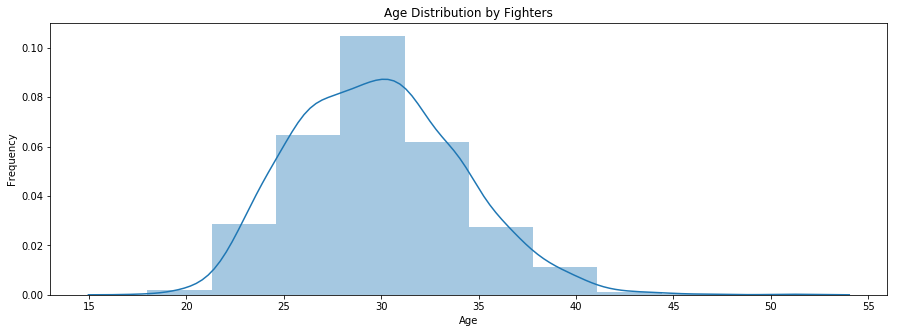

In [11]:
plt.rcParams['figure.figsize'] = (15,5)
df_rage = data[['R_fighter','R_age']].copy()
df_rage = df_rage.rename(columns={'R_fighter' : 'fighter', 'R_age' : 'age'})
df_bage = data[['B_fighter', 'B_age']].copy()
df_bage = df_bage.rename(columns={'B_fighter' : 'fighter', 'B_age' : 'age'})
df_aux = df_rage.append(df_bage, sort=False, ignore_index=True)
df_aux.drop_duplicates(subset='fighter', keep='first', inplace=True)
sns.distplot(df_aux['age'], bins=10)
plt.title('Age Distribution by Fighters')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Let's check de oldest UFC Fighter in the dataset.

In [12]:
print(df_aux.groupby('age').max().tail(1))

            fighter
age                
51.0  Ron van Clief


And the youngest.

In [13]:
print(df_aux.groupby('age').min().head(1))

             fighter
age                 
18.0  Sean Daugherty


The mean age is around 30, but let's investigate more, see the mean age distribution by year.

In [14]:
df_rage = data[['R_fighter','R_age','year']].copy()
df_rage = df_rage.rename(columns={'R_fighter' : 'fighter', 'R_age' : 'age'})
df_bage = data[['B_fighter', 'B_age','year']].copy()
df_bage = df_bage.rename(columns={'B_fighter' : 'fighter', 'B_age' : 'age'})
df_aux = df_rage.append(df_bage, sort=False, ignore_index=True)
df_aux.drop_duplicates(subset='fighter', keep='first', inplace=True)
df_aux = df_aux.groupby('year')['age'].mean()
values = df_aux
labels = values.index
trace = go.Bar(x=labels, y=values)
layout = go.Layout(title='Mean Age distribution by Year (1993-2019)',
                  xaxis = {'title' : 'Year'},
                  yaxis = {'title' : 'Mean Age'})
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

This conclude my EDA, maybe in the future I will explore more variables, but for now it is enough to get good insights about the datasets.

# 3. Feature Engineering (FE)

A lot of FE was done by the Dataset author, he have created so many features to work and cleaned the dataset, thanks dude!<br>
First, let's check again the dataset, extract target variable and drop useless features.

In [15]:
data.head(3)

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age,country,year
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,...,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0,USA,2019
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,...,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0,USA,2019
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,Lightweight,3,0.0,...,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0,USA,2019


147 Features seems too much, but remember that the author have done some Feature engineering.<br>
But let's start dropping old UFC Fights, because in 2000 UFC was sold to Station Casino executives Lorenzo and Frank Fertitta and business associate Dana White as reported on [Bleach Reporter](https://bleacherreport.com/articles/1614213-a-timeline-of-ufc-rules-from-no-holds-barred-to-highly-regulated) and it give to UFC a new set of rules, the Old School was ultimately with no rules! 

In [16]:
data['year'] = data['year'].astype(int)
data = data[data['year'] > 1999]
data

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age,country,year
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,...,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0,USA,2019
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,...,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0,USA,2019
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,Lightweight,3,0.0,...,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0,USA,2019
3,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",Blue,False,Bantamweight,3,0.0,...,0.0,6.0,Orthodox,162.56,172.72,135.0,26.0,29.0,USA,2019
4,Tai Tuivasa,Blagoy Ivanov,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Blue,False,Heavyweight,3,0.0,...,0.0,3.0,Southpaw,187.96,190.50,264.0,32.0,26.0,USA,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,Dave Menne,Fabiano Iha,John McCarthy,2000-03-10,"Lake Charles, Louisiana, USA",Red,False,Lightweight,3,1.0,...,0.0,0.0,Orthodox,177.80,NaN,170.0,29.0,25.0,USA,2000
4932,Bob Cook,Tiki Ghosn,John McCarthy,2000-03-10,"Lake Charles, Louisiana, USA",Red,False,Lightweight,3,0.0,...,0.0,0.0,Orthodox,175.26,NaN,170.0,23.0,NaN,USA,2000
4933,Jens Pulver,David Velasquez,John McCarthy,2000-03-10,"Lake Charles, Louisiana, USA",Red,False,Lightweight,3,0.0,...,0.0,0.0,Southpaw,170.18,177.80,145.0,NaN,25.0,USA,2000
4934,Scott Adams,Ian Freeman,Dan Severn,2000-03-10,"Lake Charles, Louisiana, USA",Red,False,Heavyweight,2,0.0,...,0.0,0.0,Southpaw,182.88,NaN,225.0,33.0,NaN,USA,2000


Time to extract the target column that predict the Winner.<br>
I created two more, country and year, and they have enough information to build a model, hence I will drop location and date.

In [17]:
target = data['Winner'].copy()
data = data.drop(columns=['date','location','Winner','Referee'])
print(f'The dataset have {data.shape[1]} features now.')

The dataset have 143 features now.


Now I will make a label enconder on the target variable, we have three classes: Draw, Red (Winner) and Blue (Winner).

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
target = le.fit_transform(target.values)

The split in Train (70%) and Test (30%) to evaluate the model.

In [19]:
from sklearn.model_selection import train_test_split

test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=test_size, random_state=42)
print(f'Input Train Shape {x_train.shape}')
print(f'Output Train Shape {y_train.shape}')
print(f'Input Test Shape {x_test.shape}')
print(f'Output Test Shape {y_test.shape}')

Input Train Shape (3455, 143)
Output Train Shape (3455,)
Input Test Shape (1481, 143)
Output Test Shape (1481,)


Let's normalize the data.

In [20]:
from sklearn.preprocessing import StandardScaler

num_cols = x_train.columns[x_train.dtypes.apply(lambda x: np.issubdtype(x, np.number))]

x_train[num_cols] = StandardScaler().fit_transform(x_train[num_cols])
x_test[num_cols] = StandardScaler().fit_transform(x_test[num_cols])

Convert all NAs to value -999, some machine learning algorithms can identify NAs with this value.

In [21]:
x_train = x_train.fillna(-999)
x_test = x_test.fillna(-999)

First, I will build a simple model with Catboost to see the predicitions with all features.

# 4. Model

To make this task, I will build a model using Catboost classifier and check the model prediction with Precision, Recall and F1-Score.<br>
Catboost is a good choice when we have too many categorical values on the features, it can handle without label encoder. <br>
Get which features are categorical and store it on vector.

In [22]:
cat_features = np.where(x_train.dtypes != float)[0]

First, let's search for the best hyperparameters with GridSearch.

In [23]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer

In [24]:
'''
%%time

custom_scorer = make_scorer(precision_score, average = 'macro')

parameters = {
              'iterations': [200, 400, 600, 800],
              'depth': [4, 7, 9, 11],
              'learning_rate': [0.01, 0.01, 0.05],
              'l2_leaf_reg' : [1, 3, 5, 7, 9]
}

model_grid = CatBoostClassifier(random_state = 42, task_type="GPU", silent=True, od_type="Iter")
clf_grid = GridSearchCV(model_grid, parameters, cv=3, scoring=custom_scorer)
clf_grid.fit(x_train, y_train, cat_features=cat_features)
print('Best Parameters: ', clf_grid.best_params_)
print('Best Precision: ', clf_grid.best_score_)
'''

'\n%%time\n\ncustom_scorer = make_scorer(precision_score, average = \'macro\')\n\nparameters = {\n              \'iterations\': [200, 400, 600, 800],\n              \'depth\': [4, 7, 9, 11],\n              \'learning_rate\': [0.01, 0.01, 0.05],\n              \'l2_leaf_reg\' : [1, 3, 5, 7, 9]\n}\n\nmodel_grid = CatBoostClassifier(random_state = 42, task_type="GPU", silent=True, od_type="Iter")\nclf_grid = GridSearchCV(model_grid, parameters, cv=3, scoring=custom_scorer)\nclf_grid.fit(x_train, y_train, cat_features=cat_features)\nprint(\'Best Parameters: \', clf_grid.best_params_)\nprint(\'Best Precision: \', clf_grid.best_score_)\n'

And now time to train and test the model with the best hyperparameters discovered.

In [25]:
#depht = clf_grid.best_params_['learning_rate']
#iterations = clf_grid.best_params_['iterations']
#l2_leaf_reg = clf_grid.best_params_['l2_leaf_reg']
#learning_rate = clf_grid.best_params_['depth']
depth = 10 
iterations = 800 
l2_leaf_reg = 3 
learning_rate = 0.01

In [26]:
%%time
from sklearn.metrics import precision_score, recall_score, f1_score

average='macro'

model = CatBoostClassifier(task_type="GPU",
                             learning_rate=learning_rate, 
                             iterations=iterations, 
                             l2_leaf_reg=l2_leaf_reg,
                             random_seed=42, 
                             od_type="Iter",
                             depth=depth, 
                             silent=True)


model.fit(x_train, y_train, cat_features=cat_features)
train_pred = model.predict(x_train)
precision_train = precision_score(y_train, train_pred, average=average)
recall_train = recall_score(y_train, train_pred, average=average)
f1score_train = f1_score(y_train, train_pred, average=average)
print(f'Precision (Train): {precision_train}')
print(f'Recall (Train): {recall_train}')
print(f'F1-Score (Train): {f1score_train}')
test_pred = model.predict(x_test)
precision_test = precision_score(y_test, test_pred, average=average)
recall_test = recall_score(y_test, test_pred, average=average)
f1score_test = f1_score(y_test, test_pred, average=average)
print(f'Precision (Test): {precision_test}')
print(f'Recall (Test): {recall_test}')
print(f'F1-Score (Test): {f1score_test}')

Precision (Train): 0.6426622241379492
Recall (Train): 0.640383056906345
F1-Score (Train): 0.6411356329073791
Precision (Test): 0.4411604292657887
Recall (Test): 0.4248588797221016
F1-Score (Test): 0.4254945931248282
CPU times: user 1min 39s, sys: 42.7 s, total: 2min 22s
Wall time: 1min 46s


Let's try to improve the predictions with Features importance.<br>
Got from this nice [Kernel](https://www.kaggle.com/carlolepelaars/pubg-data-exploration-rf-funny-gifs/output)

In [27]:
## Something went wrong when importing fastai.structured.
## We fixed this by put the whole source code of fastai.structured in the notebook.
## This was copied from: https://github.com/anandsaha/fastai.part1.v2/blob/master/fastai/structured.py

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz

def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.
    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.
    Returns:
    --------
    return value: A random sample of n rows of df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    >>> get_sample(df, 2)
       col1 col2
    2     3    a
    1     2    b
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def proc_df(df, y_fld, skip_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):

    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    do_scale: Standardizes each column in df,Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time(mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    y = df[y_fld].values
    df.drop(skip_flds+[y_fld], axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    res = [pd.get_dummies(df, dummy_na=True), y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [28]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'Feature':df.columns, 'Importance':m.feature_importances_}
                       ).sort_values('Importance', ascending=False)


fi = rf_feat_importance(model, x_train); fi[:10]

,Feature,Importance
142,year,12.402711
0,R_fighter,8.626379
1,B_fighter,7.649224
139,B_age,3.287881
118,R_avg_opp_SIG_STR_pct,2.252037
140,R_age,1.931117
114,R_avg_opp_PASS,1.436151
111,R_avg_opp_KD,1.425557
92,R_avg_SIG_STR_pct,1.362266
55,B_avg_opp_TD_pct,1.228207


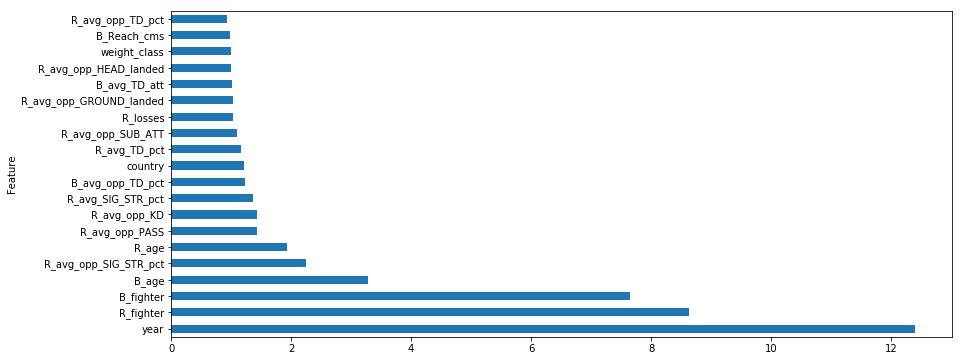

In [29]:
# Plot a feature importance graph for the 20 most important features
plot1 = fi[:20].plot('Feature', 'Importance', figsize=(14,6), legend=False, kind = 'barh')
plot1;

In [30]:
# Keep only significant features
to_keep = fi[fi.Importance>0.05].Feature
print('Significant Features: ', len(to_keep))
to_keep

Significant Features:  133


142                       year
0                    R_fighter
1                    B_fighter
139                      B_age
118      R_avg_opp_SIG_STR_pct
                ...           
127        R_total_title_bouts
62     B_win_by_Decision_Split
32        B_longest_win_streak
131            R_win_by_KO/TKO
64             B_win_by_KO/TKO
Name: Feature, Length: 133, dtype: object

In [31]:
# Make a DataFrame with only significant features
x_train = x_train[to_keep].copy()
x_test = x_test[to_keep].copy()

And train again with the best features.

In [32]:
cat_features = np.where(x_train.dtypes != float)[0]

model.fit(x_train, y_train, cat_features=cat_features)
train_pred = model.predict(x_train)
precision_train = precision_score(y_train, train_pred, average=average)
recall_train = recall_score(y_train, train_pred, average=average)
f1score_train = f1_score(y_train, train_pred, average=average)
print(f'Precision (Train): {precision_train}')
print(f'Recall (Train): {recall_train}')
print(f'F1-Score (Train): {f1score_train}')
test_pred = model.predict(x_test)
precision_test = precision_score(y_test, test_pred, average=average)
recall_test = recall_score(y_test, test_pred, average=average)
f1score_test = f1_score(y_test, test_pred, average=average)
print(f'Precision (Test): {precision_test}')
print(f'Recall (Test): {recall_test}')
print(f'F1-Score (Test): {f1score_test}')

Precision (Train): 0.6446130225186555
Recall (Train): 0.6424528300660198
F1-Score (Train): 0.64315554020654
Precision (Test): 0.4453683283871963
Recall (Test): 0.42653061224489797
F1-Score (Test): 0.4274453236456311


A look into the Confusion Matrix.

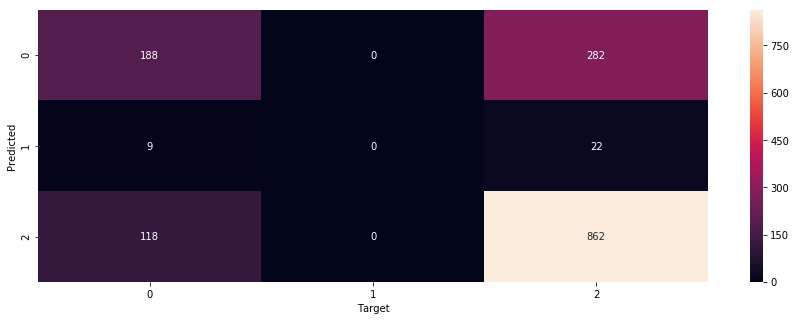

In [33]:
# Plot Matrix Confusion
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, test_pred)
ax = sns.heatmap(cf, annot=True, fmt="d")
ax.set_ylabel('Predicted')
ax.set_xlabel('Target')
ax.set_ylim(3, 0);

# 5. Conclusion

The CatBoost Classifier still needs tuning, I will update as soon.
Thanks for the reading!
